In [82]:
## Import libraries
import math
import matplotlib
import matplotlib.pyplot as plt
## remove this line when running script from terminal, keep it when running notebooks
%matplotlib inline 

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz # to plot the decission tree
import os # to join pathrs, etc..
import pickle # to store the models

In [2]:
## Define filenames and sutff
peaks_path = 'output'
labels_path = 'all_labels.txt'

# reads labels into a df
train_labels_df = pd.read_csv(labels_path, sep="\t")
## take care because there are duplicates!!!!!!!!!
train_labels_df = train_labels_df.drop_duplicates(subset='file').reset_index(drop=True)
## adding a column for the labels with the id of the label
labels = train_labels_df['candy'].unique()
train_labels_df['candy_id'] = np.where(labels == train_labels_df['candy'][:,None])[-1]

In [3]:
print "Total of %i files with peaks"% train_labels_df['file'].shape[0]

peaks_files = [ os.path.join(peaks_path, file) for file in train_labels_df['file'] ]

Total of 23 files with peaks


In [4]:

results_folder = 'results'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Part 2

## Step 7

Create a peak alignment matrix with the new data

In [168]:
#peaks_files.pop(1)
#train_labels_df = train_labels_df.drop(1).reset_index(drop=True)

In [155]:
def read_files( paths ):
    # reads all the files
    raw_peaks = [pd.read_csv(path, sep="\t") for path in paths ]
    # combines them all in one dataframe
    df = pd.concat(raw_peaks).reset_index(drop=True)
    # converts peak_name column into integers
    peaks = [ int(peak.replace('p','')) for peak in df['peak_name']] 
    df['peak_name'] = peaks
    return df

def align_peaks( data, peaks=90):
    KM = KMeans(n_clusters=peaks, n_init=100)
    KM.fit(data[['t', 'r']])
    data['cluster_id'] = KM.labels_
    return KM, data
    
def create_train_matrix( data , n_clusters):
    total_clusters = n_clusters
    d = { colname: [0] * total_clusters for colname in data['measurement_name'].unique() }
    matrix = pd.DataFrame(data=d)
    ## fill the matrix
    for name in data['measurement_name'].unique():
        patient = data[data['measurement_name'] == name]
        clusters = patient['cluster_id']
        #for cluster in clusters:
        matrix[name][clusters] = 1
    
    return matrix.transpose()

raw_df = read_files( peaks_files )

In [179]:
CLUSTERS = int(np.average([ raw_df[raw_df['measurement_name'] == name].shape[0] for name in raw_df['measurement_name'].unique()]) * 1.5)
CLUSTERS

98

In [155]:
k_means, aligned_df = align_peaks( raw_df ,peaks = CLUSTERS)
train_matrix_df = create_train_matrix(aligned_df, k_means.n_clusters)

print "Showing head of the matrix"
train_matrix_df.head()

Showing head of the matrix


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
BD18_1711291646_ims.csv,0,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
BD18_1711291652_ims.csv,0,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BD18_1711291656_ims.csv,0,1,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
BD18_1711291702_ims.csv,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
BD18_1711291705_ims.csv,0,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Step 8

Train random forest classifier

In [156]:
g_rf = RandomForestClassifier(n_estimators=20)
g_rf = g_rf.fit(train_matrix_df.as_matrix(), train_labels_df['candy'])

In [157]:
prediction = g_rf.predict(train_matrix_df.as_matrix())

In [158]:
confusion_matrix(train_labels_df['candy'], prediction)

array([[10,  0],
       [ 0, 12]])

## Step 9

Implement 5-fold cross validation


In [159]:
def k_cross_fold_validation( data, labels, k=5):
    """Returns the predictions and the indexes of each test slice"""
    rf = RandomForestClassifier(n_estimators=25)
    predictions, indexes = [], []
    size = data.shape[0]
    step_size = int(size / 5)
    for i in range(k):
        indexes.append(range(i*k, min(i*k + k, size)))
        xtrain = np.array(data)
        ytrain = np.array(labels)

        # picks test slices
        xtest = xtrain[i*k:i*k + k]
        ytest = ytrain[i*k:i*k + k]

        # removes test slices from the training sets
        xtrain = np.delete(xtrain, np.s_[i*k:i*k + k], axis=0)
        ytrain = np.delete(ytrain, np.s_[i*k:i*k + k], axis=0)

        
        rf = rf.fit(xtrain, ytrain)
        prediction = rf.predict(xtest)

        predictions.append(prediction.tolist())
        
    return np.array(predictions), np.array(indexes)

pred, indexes = k_cross_fold_validation(train_matrix_df.as_matrix(), train_labels_df['candy'])

## Step 10 
Report the mean accuracy, sensitivity and specificity

In [160]:
def report_mean( preds, trues):
    flatten_pred = np.hstack(preds)
    results = np.zeros(trues.unique().shape[0])
    for i, label in enumerate(trues.unique()):
        # indexes for such label
        class_trues =  np.argwhere(trues == label).ravel()
        # predicted label on such indexes
        predicted = flatten_pred[class_trues]

        results[i] = np.count_nonzero(predicted == label) / float(len(class_trues))
    return results.mean()

mean_accuracy = report_mean(pred, train_labels_df['candy'])
print "Mean Accuracy: ", mean_accuracy

Mean Accuracy:  0.866666666667


In [161]:
def report_sens_spec( pred, trues):
    preds = np.hstack(pred)
    classes = trues.unique()
    # report sensitivity for each class
    for label in classes:
        print label.capitalize()
        # indexes for such label
        class_trues =  np.argwhere(trues == label).ravel()
        class_falses =  np.argwhere(trues != label).ravel()

        pred_trues = np.argwhere(preds == label).ravel()
        pred_falses = np.argwhere(preds != label).ravel()

        TP = sum([ 1. for p in pred_trues if p in class_trues ])
        TN = sum([ 1. for p in pred_falses if p in class_falses ])
        FN = sum([ 1. for p in pred_falses if p in class_trues ])
        
        sen = TP / (TP + FN)
        spec = TN / (TN + FN)
        print "Sensitivity: ", sen
        print "Specificity: ", spec
    
report_sens_spec(pred, train_labels_df['candy'])    

Citrus
Sensitivity:  0.9
Specificity:  0.909090909091
Halls
Sensitivity:  0.833333333333
Specificity:  0.818181818182


## Step 11
Extract the five most discriminating features (peaks) by using the Gini index

In [169]:

def most_discriminating( features_df, labels_df, top=5):
    """Uses gini index impurity as a splitting criteria, 
    only works for two classes. 
    Maximizes the information gain, so we return the "top" indexes
    with the highest quality value, the closer to 1 the better
    
                          c        h
                      +--------+--------+
     c -> Citrus      |        |        |
     h -> Halls     A | P(c|A) | P(h|A) |
     c = 0            |        |        |
     h = 1            +-----------------+
                               |
               +-----<-left(0)-+-right(1)->----+
           c   |   h                       c   |  h
      +-----------------+             +-----------------+
      |        |        |             |        |        |
    B | P(c|B) | P(h|B) |           C | P(c|C) | P(h|C) |
      |        |        |             |        |        |
      +--------+--------+             +--------+--------+
    
    """
    
    columns = features_df.shape[1]
    labels_df = labels_df[['file', 'candy_id']].set_index('file')
    qualities = np.zeros(columns)
    
    _left = 0
    _right = 1

    _c = 0
    _h = 1

    # globals
    cases = float(labels_df['candy_id'].count()) # total cases

    p_c_A = (labels_df['candy_id'] == 0).sum() / cases
    p_h_A = 1.0 - p_c_A


    for feature in range(columns):

        branch_cases = np.zeros(2) # total on each branch
        pi = np.zeros(2)     # proportion on each branch

        split = np.array([
            #c, h
            [0, 0], #left
            [0, 0]  #right
        ])

        for index, value in features_df[feature].iteritems():
            split[value][labels_df.loc[index][0]] += 1

        branch_cases[_left] = split[_left].sum()
        branch_cases[_right] = split[_right].sum()
        
        if branch_cases[_left] == 0.0 or branch_cases[_right] == 0.0:
            qualities[feature] = 0
            continue
        
        pi[_left] = branch_cases[_left] / cases
        pi[_right] = branch_cases[_right] / cases

        p_c_B = split[_left][_c] / branch_cases[_left]
        p_h_B = split[_left][_h] / branch_cases[_left]

        p_c_C = split[_right][_c] / branch_cases[_right]
        p_h_C = split[_right][_h] / branch_cases[_right]

        gini_tree = 1.0 - (math.pow(p_c_A, 2) +  math.pow(p_h_A, 2))

        gini_left = 1.0 - (math.pow(p_c_B, 2) +  math.pow(p_h_B, 2))
        gini_right = 1.0 - (math.pow(p_c_C, 2) +  math.pow(p_h_C, 2))

        quality = gini_tree - pi[_left] * gini_left - pi[_right] * gini_right

        qualities[feature] = quality
    return list(reversed(qualities.argsort()))[:top]

In [170]:
best_features = most_discriminating(train_matrix_df, train_labels_df)
print best_features

[13, 8, 63, 74, 32]


In [171]:
def test_splitting_on_feature(num = 0):
    """useful function to test splittings"""
    left =  [0,0]
    right = [0,0]
    for i, side in enumerate(train_matrix_df[num]):
        if int(side) == 0: 
            if train_labels_df.ix[i]['candy_id'] == 0:
                left[0] += 1
            else:
                left[1] += 1
        else:
            if train_labels_df.ix[i]['candy_id'] == 0:
                right[0] += 1
            else:
                right[1] += 1

        #print " %s goes to the %i side" %(train_labels_df.ix[i]['candy'], side)

    print str(left) + "<--left -- + -- right-->" + str(right)
test_splitting_on_feature(13)

[0, 10]<--left -- + -- right-->[10, 2]


## Step 12

Learn and plot/report a decision tree by using only these
five best features/peaks.

In [172]:
d_tree = tree.DecisionTreeClassifier()
tree_train_features = train_matrix_df[best_features].as_matrix()
tree_train_labels = train_labels_df['candy']

In [173]:
d_tree = d_tree.fit(tree_train_features, tree_train_labels)

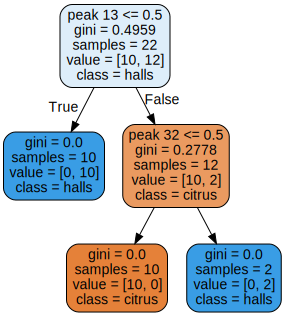

In [174]:
# check you have installed graphviz

dot_data = tree.export_graphviz(d_tree, out_file=None,
                                feature_names = ['peak ' + str(peak) for peak in best_features],
                                class_names=train_labels_df['candy'].unique(),
                                filled=True, rounded=True)  
# two steps, one for saving
graphviz.Source(dot_data, format='png').render(os.path.join(results_folder, "tree"))

# second for showing
graphviz.Source(dot_data)


### Stores the models

In [175]:
#### Stores decission tree and random forests as pickle
def store_model( model, name ):
    name = name + ".pck"
    name = os.path.join(results_folder, name)
    with open(name, 'w') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    print "File stored at " + name


In [176]:
store_model(g_rf, "model_random_forests")

File stored at results/model_random_forests.pck


In [177]:
store_model(d_tree, "model_decision_tree")

File stored at results/model_decision_tree.pck


In [178]:
store_model(k_means, "model_k_means")

File stored at results/model_k_means.pck


In [102]:
#g_rf = RandomForestClassifier()
#g_rf = g_rf.fit(train_matrix_df[best_features].as_matrix(), train_labels_df['candy'])